# LLM Output Similarity Experiment

## 1. Introduction - Preliminaries

**v1.0** — Bare-bones comparison of LLM outputs using two aggregate similarity metrics:
- **Cosine similarity** of local embeddings (semantic).

### Prerequisites
1. Copy `.env.example` → `.env` and fill in your model configs.
2. Edit `prompts.txt` (separate entries with a line containing only `---`).
3. Edit `system_prompt.txt` with your desired system prompt.
4. Ensure all referenced Ollama models are pulled: `ollama pull <model>`.

### Milestones
| # | Scope |
|---|-------|
| M1 | Inputs / config / prompt loading / normalization |
| M2 | Unified HTTP client + inference loop + `responses_df` |
| M3 | Embeddings → cosine similarity → aggregate heatmap |

In [1]:
# ── Imports ────────────────────────────────────────────────────────────────────
import json
import os
import re
import time
from datetime import datetime, timezone
from itertools import combinations

import httpx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

import ipywidgets as widgets
from IPython.display import display, Markdown


---
## 2. Inputs, Configuration & Normalization

### 2.1 Configuration and Models Loading

Note that models are not actually loaded, only their configuration read. Models will be cold loaded for each separate prompt.

In [2]:
# ── FR-1 / FR-2: Load model configs from .env ─────────────────────────────────
load_dotenv()

# Read the JSON string from the json file and parse it into a dictionary
with open("llm_models_json.json", "r") as f:
    _models_json_raw = f.read()
print(_models_json_raw)  # Debug: print raw JSON string to verify it's loaded correctly
MODELS: dict[str, dict] = json.loads(_models_json_raw)

# Validate each alias
# NFR-1: Ensure all required keys are present and valid
_REQUIRED_KEYS = {"kind", "provider", "model", "base_url", "api_key"}
# Kinds: generator = text generation, embedder = vector embedding, judge = evaluation/scoring
_VALID_KINDS   = {"generator", "embedder", "judge"}

# Report any missing keys or invalid kinds before proceeding
for _alias, _cfg in MODELS.items():
    _missing = _REQUIRED_KEYS - _cfg.keys()
    assert not _missing, f"Model '{_alias}' is missing required keys: {_missing}"
    assert _cfg["kind"] in _VALID_KINDS, (
        f"Model '{_alias}' has invalid kind '{_cfg['kind']}'. Must be one of {_VALID_KINDS}."
    )

# NFR-1: Show redacted config (never print api_key)
print(f"Loaded {len(MODELS)} model(s):")
for _alias, _cfg in MODELS.items():
    _safe = {k: ("***" if k == "api_key" else v) for k, v in _cfg.items()}
    print(f"  {_alias}: {_safe}")

{
 "qwen2.5:1.5b-instruct": {
    "kind": "generator",
    "provider": "openai_compatible",
    "model": "qwen2.5:1.5b-instruct",
    "base_url": "http://localhost:11434",
    "api_key": "ollama"
  },
  "qwen3:1.7b": {
    "kind": "generator",
    "provider": "openai_compatible",
    "model": "qwen3:1.7b",
    "base_url": "http://localhost:11434",
    "api_key": "ollama"
  },
  "qwen:1.8b": {
    "kind": "generator",
    "provider": "openai_compatible",
    "model": "qwen:1.8b",
    "base_url": "http://localhost:11434",
    "api_key": "ollama"
  },
  "qwen2.5:3b-instruct": {
    "kind": "generator",
    "provider": "openai_compatible",
    "model": "qwen2.5:3b-instruct",
    "base_url": "http://localhost:11434",
    "api_key": "ollama"
  },
    "qwen3:4b": {
    "kind": "generator",
    "provider": "openai_compatible",
    "model": "qwen3:4b",
    "base_url": "http://localhost:11434",
    "api_key": "ollama"
  },
    "qwen2.5:7b-instruct": {
    "kind": "generator",
    "provider": "op

### 2.2 System Prompt

In [3]:
# ── FR-3: Load system prompt with max-lines and approx max-tokens enforcement ──
SYSTEM_PROMPT_FILE      = os.environ.get("SYSTEM_PROMPT_FILE",      "system_prompt.txt")
MAX_SYSTEM_LINES        = int(os.environ.get("MAX_SYSTEM_LINES",        "100"))
MAX_SYSTEM_TOKENS_APPROX = int(os.environ.get("MAX_SYSTEM_TOKENS_APPROX", "1500"))

def load_system_prompt(path: str, max_lines: int, max_tokens_approx: int) -> str:
    """Load system prompt from *path*, truncating by line count and approx token count.
    Args:
        path: Path to the system prompt file.
        max_lines: Maximum number of lines to read.
        max_tokens_approx: Approximate maximum number of tokens.
    Returns:
        The loaded system prompt as a string, truncated according to the specified limits.
    """
    with open(path, "r", encoding="utf-8") as fh:
        lines = fh.readlines()

    # Warn of truncation if file exceeds line limit
    if len(lines) > max_lines:
        print(
            f"Warning: System prompt has {len(lines)} lines, exceeding the max of {max_lines}. "
            f"Truncating to the first {max_lines} lines."
        )

    # Hard line-count cap
    lines = lines[:max_lines]
    text  = "".join(lines)

    # Warn of truncation if text exceeds approx token limit
    if len(text) > max_tokens_approx * 4:
        print(
            f"Warning: System prompt has approximately {len(text) // 4} tokens, "
            f"exceeding the approx max of {max_tokens_approx}. "
            f"Truncating to the first {max_tokens_approx * 4} characters."
        )

    # Heuristic: ~4 chars per token
    max_chars = max_tokens_approx * 4
    if len(text) > max_chars:
        text = text[:max_chars]

    return text.strip()

# Load the system prompt with the specified limits
system_prompt = load_system_prompt(
    SYSTEM_PROMPT_FILE, MAX_SYSTEM_LINES, MAX_SYSTEM_TOKENS_APPROX
)
print(f"System prompt ({len(system_prompt)} chars):")
print(system_prompt)

System prompt (37 chars):
Limit responses to 500 words or less.


In [4]:
# ── FR-2 (cont.): Load prompts from .txt split by delimiter '---' ──────────────
PROMPTS_FILE = os.environ.get("PROMPTS_FILE", "prompts.txt")
DELIMITER    = "---"

with open(PROMPTS_FILE, "r", encoding="utf-8") as prompts_file:
    _raw_prompts = prompts_file.read()

# Split on lines that contain *only* the delimiter (strip surrounding whitespace)
_raw_parts = re.split(r"(?m)^---\s*$", _raw_prompts)
prompts: list[str] = [p.strip() for p in _raw_parts if p.strip()]

print(f"Loaded {len(prompts)} prompt(s):")
for _i, _p in enumerate(prompts):
    _preview = _p[:120].replace("\n", " ")
    print(f"  [prompt_{_i}] {_preview}{'...' if len(_p) > 120 else ''}")

Loaded 8 prompt(s):
  [prompt_0] Explain prompting.
  [prompt_1] Explain how prompts influence the output of LLM chatbots, what characteristics they must have for them to be effective, ...
  [prompt_2] Explain LLM chatbot prompting with examples.
  [prompt_3] Explain how LLM chatbot prompting works efficiently using this format: Summary Basic characteristics good prompts must h...
  [prompt_4] Explain LLM chatbot prompting, what works, and what does not work.
  [prompt_5] You are a professional and helpful prompt engineer with a machine learning background. Explain how efficient LLM chatbot...
  [prompt_6] Role: You are a professional and helpful prompt engineer with a machine learning andAI engineering background, assigned ...
  [prompt_7] Role: Act as a professional prompt engineer (ML + AI engineering background) mentoring junior colleagues at an internati...


In [5]:
# ── Output normalisation (applied before embeddings + NLI) ────────────────────
def normalize_response(text: str,
                       word_limit: int = 5000) -> str:
    """Normalize LLM output for downstream similarity scoring.

    Steps (in order):
    1. Strip leading/trailing whitespace.
    2. Normalize line endings to \\n.
    3. Remove standalone markdown fence lines (e.g. ```python) — *keep* content.
    4. Collapse multiple spaces/tabs → single space (preserving newlines).
    5. Collapse 3+ consecutive newlines → 2 newlines.
    6. Final strip.

    Args:
        text: The raw text output from the LLM.
        word_limit: The maximum number of words to keep in the normalized text.
    Returns:
        The normalized text, cleaned according to the steps above.
    """
    text = text.strip()
    # Step 2: normalize line endings
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    # Step 3: remove standalone fence lines (``` or ```lang) — keep code content
    text = re.sub(r"(?m)^```[a-zA-Z0-9_+-]*\s*$", "", text)
    # Step 4: collapse multiple spaces / tabs (not newlines)
    text = re.sub(r"[ \t]+", " ", text)
    # Step 5: collapse 3+ newlines → 2
    text = re.sub(r"\n{3,}", "\n\n", text)
    # Step 6: enforce word limit
    if word_limit > 0:
        words = text.split()
        if len(words) > word_limit:
            text = " ".join(words[:word_limit])
    return text.strip()


# Smoke test
_sample = "  Hello  \r\n\n\n\n```python\nprint('hi')\n```\n  World  "
print(repr(normalize_response(_sample)))

"Hello \n\nprint('hi')\n\n World"


---
## 3. Unified OpenAI-Compatible Client & Inference Loop

### 3.1 Client Class Declaration

We create a generalized wrapper class around the OpenAI-compatible HTTP API, with which we will be calling our models regardless of role in the experiment.

In [6]:
# ── FR-4: Unified OpenAI-compatible HTTP client ────────────────────────────────
_MAX_RETRIES          = 3
_RETRY_STATUSES       = {429, 500, 502, 503, 504}
_BASE_BACKOFF_S       = 1.0    # seconds
_REQUEST_TIMEOUT      = 120.0  # seconds — used for non-streaming calls (embed, etc.)
_STREAM_TTFT_TIMEOUT  = 90.0   # seconds — time to first token (model may need to load weights)
_STREAM_TOKEN_TIMEOUT = 30.0   # seconds — max wait between tokens once streaming has started


class LLMClient:
    """Thin wrapper around the OpenAI-compatible HTTP API.

    All model-specific details (base_url, api_key, model name) are resolved
    from the *models* config dict by alias. Retries with exponential backoff
    are applied automatically on 429 / 5xx responses (NFR-2).
    Args:
    - models: A dict mapping model aliases to their config dicts, which must include:
        - kind: "generator", "embedder", or "judge"
        - provider: e.g. "openai", "azure", "anthropic"
        - model: the model name to use in API calls
        - base_url: the base URL for API calls (e.g. "https://api.openai.com/v1")
        - api_key: the API key for authentication (never printed in logs)
    Returns:
    - An instance of LLMClient that can be used to make chat and embedding requests.
    """

    def __init__(self, models: dict[str, dict]) -> None:
        self._models = models

    # ── public interface ──────────────────────────────────────────────────────

    def chat(
        self,
        alias: str,
        messages: list[dict],
        **params,
    ) -> dict:
        """POST /v1/chat/completions for *alias* with the given *messages*.
        Args:
            alias: The model alias to use (must be defined in the config).
            messages: The list of message dicts to send in the chat completion request.
            **params: Additional parameters to include in the request body (e.g. temperature).
        Returns:
            The JSON response from the API as a dict.
        """
        cfg = self._get_cfg(alias)
        url = cfg["base_url"].rstrip("/") + "/v1/chat/completions"
        body: dict = {
            "model":       cfg["model"],
            "messages":    messages,
            "temperature": 0,        # NFR-3: deterministic by default
            "stream":      True,     # use streaming to detect generation progress
            **params,
        }
        body.update(cfg.get("extra") or {})
        return self._post_with_retry(url, self._headers(cfg), body)

    def embed(
        self,
        alias: str,
        texts: list[str],
    ) -> list[list[float]]:
        """POST /v1/embeddings for *alias*, returning a list of embedding vectors.
        Args:
            alias: The model alias to use (must be defined in the config).
            texts: The list of input texts to embed.
        Returns:
            A list of embedding vectors (one per input text)."""
        cfg = self._get_cfg(alias)
        url = cfg["base_url"].rstrip("/") + "/v1/embeddings"
        body: dict = {"model": cfg["model"], "input": texts}
        resp = self._post_with_retry(url, self._headers(cfg), body)
        return [item["embedding"] for item in resp["data"]]

    # ── private helpers ───────────────────────────────────────────────────────

    def _get_cfg(self, alias: str) -> dict:
        """Retrieve the configuration for a given model alias.
        Args:
            alias: The model alias to look up.
        Returns:
            The configuration dictionary for the specified model alias.
        Raises:
            KeyError: If the alias is not found in the models dictionary.
        """
        if alias not in self._models:
            raise KeyError(f"Unknown model alias: '{alias}'. Known: {list(self._models)}")
        return self._models[alias]

    @staticmethod
    def _headers(cfg: dict) -> dict:
        """Generate headers for the API request.
        Args:
            cfg: The model configuration dictionary.
        Returns:
            A dictionary of headers for the API request.
        """
        headers = {"Content-Type": "application/json"}
        api_key = cfg.get("api_key", "")
        # Take care of no API key of local or hosted models (e.g. "ollama", "none", "no_key_required")
        if api_key and api_key.lower() not in ("", "none", "ollama", "no_key_required"):
            headers["Authorization"] = f"Bearer {api_key}"
        return headers

    def _stream_response(self, http: httpx.Client, url: str, headers: dict, body: dict) -> dict:
        """Stream the response from the API, reassembling chunks into a standard response dict.

        Uses a generous TTFT timeout for the first token (model may need to load weights),
        then switches to a tighter inter-token timeout once generation is confirmed.
        Args:
            http: The httpx.Client instance to use for the request.
            url: The URL to send the POST request to.
            headers: The headers to include in the request.
            body: The JSON body to include in the request.
        Returns:
            The JSON response from the API as a dict.
        """
        full_content  = ""
        finish_reason = None
        first_token   = False

        with http.stream(
            "POST", url, headers=headers, json=body,
            timeout=httpx.Timeout(
                connect=10.0,
                read=_STREAM_TTFT_TIMEOUT,   # generous wait for first token
                write=10.0,
                pool=5.0,
            ),
        ) as r:
            r.raise_for_status()
            for line in r.iter_lines():
                if not line.startswith("data: "):
                    continue
                data = line[len("data: "):]
                if data.strip() == "[DONE]":
                    break
                try:
                    chunk = json.loads(data)
                    delta = chunk["choices"][0].get("delta", {})
                    token = delta.get("content") or ""

                    if token and not first_token:
                        # Switch to the tighter inter-token timeout after first token arrives
                        first_token = True
                        r._timeout = httpx.Timeout(   # type: ignore[attr-defined]
                            connect=10.0,
                            read=_STREAM_TOKEN_TIMEOUT,
                            write=10.0,
                            pool=5.0,
                        )

                    full_content  += token
                    finish_reason  = chunk["choices"][0].get("finish_reason")
                except (json.JSONDecodeError, KeyError, IndexError):
                    continue

        return {
            "choices": [{
                "message":       {"role": "assistant", "content": full_content},
                "finish_reason": finish_reason,
            }]
        }

    def _post_with_retry(self, url: str, headers: dict, body: dict) -> dict:
        """POST request with retries on 429 / 5xx responses.

        Delegates to _stream_response when body["stream"] is True,
        otherwise falls back to a standard blocking POST.
        Args:
            url: The URL to send the POST request to.
            headers: The headers to include in the request.
            body: The JSON body to include in the request.
        Returns:
            The JSON response from the API as a dict.
        """
        backoff    = _BASE_BACKOFF_S
        last_exc: Exception | None = None
        is_stream  = body.get("stream", False)

        for attempt in range(_MAX_RETRIES):
            try:
                with httpx.Client(timeout=_REQUEST_TIMEOUT) as http:
                    if is_stream:
                        return self._stream_response(http, url, headers, body)

                    r = http.post(url, headers=headers, json=body)

                    if r.status_code in _RETRY_STATUSES and attempt < _MAX_RETRIES - 1:
                        time.sleep(backoff)
                        backoff *= 2
                        continue

                    r.raise_for_status()
                    return r.json()

            except httpx.HTTPStatusError as exc:
                last_exc = exc
                if exc.response.status_code not in _RETRY_STATUSES or attempt == _MAX_RETRIES - 1:
                    raise
                time.sleep(backoff)
                backoff *= 2

            except (httpx.TimeoutException, httpx.ConnectError) as exc:
                last_exc = exc
                if attempt == _MAX_RETRIES - 1:
                    raise
                time.sleep(backoff)
                backoff *= 2

        raise last_exc  # type: ignore[misc]


client = LLMClient(MODELS)
print("LLMClient ready.")


LLMClient ready.


### 3.2 Inference Loop

We now use our previous defined wrapper class to loop over prompts x models and store the responses. Note that we iterate over models for each prompt separately, despite increased latency. This is intentional so that each response is cold started, and the model does not have any previous context when responding.

In [12]:
# ── FR-5 / FR-6 (responses_df): Run inference across all generator × prompts ──
generator_aliases = [
    alias for alias, cfg in MODELS.items() if cfg["kind"] == "generator"
]
print(f"Generator aliases: {generator_aliases}")
print(f"Running {len(prompts)} prompt(s) × {len(generator_aliases)} model(s) …\n")

records: list[dict] = []

# We intentionally run each model cold for each prompt to avoid context
# between prompts.
for prompt_id, prompt_text in enumerate(prompts):
    for alias in generator_aliases:
        messages: list[dict] = []
        if system_prompt:
            messages.append({"role": "system", "content": system_prompt})
        messages.append({"role": "user", "content": prompt_text})

        t0     = time.time()
        status = "ok"
        response_raw = ""
        error: str | None = None

        try:
            resp         = client.chat(alias, messages)
            response_raw = resp["choices"][0]["message"]["content"]
        except Exception as exc:  # noqa: BLE001
            status = "error"
            error  = str(exc)
            print(f"  [WARN] prompt_{prompt_id} / {alias} → {exc}")

        latency_ms    = round((time.time() - t0) * 1000, 1)
        response_norm = normalize_response(response_raw, word_limit=5000) if status == "ok" else ""

        records.append({
            "prompt_id":     prompt_id,
            "model_alias":   alias,
            "response_raw":  response_raw,
            "response_norm": response_norm,
            "status":        status,
            "latency_ms":    latency_ms,
            "created_at":    datetime.now(timezone.utc).isoformat(),
            "error":         error,
        })
        _icon = "✓" if status == "ok" else "✗"
        print(f"  {_icon} prompt_{prompt_id} / {alias} ({latency_ms:.0f} ms)")

responses_df = pd.DataFrame(records)
print(f"\nresponses_df shape: {responses_df.shape}")

Generator aliases: ['qwen2.5:1.5b-instruct', 'qwen3:1.7b', 'qwen:1.8b', 'qwen2.5:3b-instruct', 'qwen3:4b', 'qwen2.5:7b-instruct']
Running 8 prompt(s) × 6 model(s) …

  ✓ prompt_0 / qwen2.5:1.5b-instruct (7619 ms)
  ✓ prompt_0 / qwen3:1.7b (8569 ms)
  ✓ prompt_0 / qwen:1.8b (6902 ms)
  ✓ prompt_0 / qwen2.5:3b-instruct (8306 ms)
  ✓ prompt_0 / qwen3:4b (19526 ms)
  ✓ prompt_0 / qwen2.5:7b-instruct (12616 ms)
  ✓ prompt_1 / qwen2.5:1.5b-instruct (8399 ms)
  ✓ prompt_1 / qwen3:1.7b (9973 ms)
  ✓ prompt_1 / qwen:1.8b (7154 ms)
  ✓ prompt_1 / qwen2.5:3b-instruct (9679 ms)
  ✓ prompt_1 / qwen3:4b (18047 ms)
  ✓ prompt_1 / qwen2.5:7b-instruct (17613 ms)
  ✓ prompt_2 / qwen2.5:1.5b-instruct (260276 ms)
  ✓ prompt_2 / qwen3:1.7b (9718 ms)
  ✓ prompt_2 / qwen:1.8b (16947 ms)
  ✓ prompt_2 / qwen2.5:3b-instruct (13402 ms)
  ✓ prompt_2 / qwen3:4b (19104 ms)
  ✓ prompt_2 / qwen2.5:7b-instruct (20505 ms)
  ✓ prompt_3 / qwen2.5:1.5b-instruct (7861 ms)
  ✓ prompt_3 / qwen3:1.7b (12041 ms)
  ✓ prompt_3 /

In [13]:
# ── Inspect responses_df ───────────────────────────────────────────────────────
pd.set_option("display.max_colwidth", 80)
responses_df[["prompt_id", "model_alias", "status", "latency_ms", "error"]]

,prompt_id,model_alias,status,latency_ms,error
0,0,qwen2.5:1.5b-instruct,ok,7619.0,None
1,0,qwen3:1.7b,ok,8569.4,None
2,0,qwen:1.8b,ok,6902.4,None
3,0,qwen2.5:3b-instruct,ok,8305.5,None
4,0,qwen3:4b,ok,19526.3,None
5,0,qwen2.5:7b-instruct,ok,12615.8,None
6,1,qwen2.5:1.5b-instruct,ok,8398.9,None
7,1,qwen3:1.7b,ok,9972.8,None
8,1,qwen:1.8b,ok,7154.5,None
9,1,qwen2.5:3b-instruct,ok,9678.8,None


In [14]:
def render(model_alias, prompt_id):
    """Render the raw response for the currently selected model and prompt.
    Args:
        model_alias: The alias of the model to display the response for.
        prompt_id: The ID of the prompt to display the response for.
    Returns:
        Displays a Markdown-formatted section with the model alias, prompt preview, and raw response text
    """
    row = responses_df[
        (responses_df["model_alias"] == model_alias) &
        (responses_df["prompt_id"] == prompt_id)
    ]
    if row.empty:
        text = "(no response found)"
    else:
        text = row.iloc[0]["response_raw"]

    prompt_preview = prompts[prompt_id][:80].replace("\n", " ")
    if len(prompts[prompt_id]) > 80:
        prompt_preview += "…"

    display(Markdown(
        f"### Response\n"
        f"**LLM:** `{model_alias}`  \n"
        f"**Prompt:** `{prompt_preview}`\n\n"
        f"{text}"
    ))

In [10]:

model_dd = widgets.Dropdown(
    options=generator_aliases,
    description="LLM:",
)
prompt_dd = widgets.Dropdown(
    options=[(f"prompt_{i}", i) for i in sorted(responses_df["prompt_id"].unique())],
    description="Prompt:",
)
widgets.interact(render, model_alias=model_dd, prompt_id=prompt_dd)


interactive(children=(Dropdown(description='LLM:', options=('qwen2.5:1.5b-instruct', 'qwen3:1.7b', 'qwen:1.8b'…

<function __main__.render(model_alias, prompt_id)>

---
## 4. Embeddings → Cosine Similarity → Aggregate Heatmap

### 4.1 Embeddings

Now that we have our responses, we need to embed them, and perform the cosine similarity between them in order to numerically compare the differences between them.

In [16]:
# ── FR-7: Embed normalized responses & compute per-prompt cosine matrices ──────
embedder_alias = next(
    (a for a, c in MODELS.items() if c["kind"] == "embedder"), None
)
if embedder_alias is None:
    raise ValueError(
        "No embedder model configured. Add an entry with kind='embedder' to LLM_MODELS_JSON."
    )

ok_df = responses_df[responses_df["status"] == "ok"].copy()

# Resolve alias -> actual model name
embedder_cfg = MODELS.get(embedder_alias, {})
embedder_model = embedder_cfg.get("model") or embedder_cfg.get("name") or embedder_alias

# Keep only valid, non-empty text
mask = ok_df["response_norm"].notna() & ok_df["response_norm"].astype(str).str.strip().ne("")
ok_df = ok_df.loc[mask].copy()
ok_df["response_norm"] = ok_df["response_norm"].astype(str).str.strip()

texts = (
    ok_df["response_norm"]
    .fillna("")
    .astype(str)
    .str.strip()
)

valid_mask = texts.ne("")
texts = texts[valid_mask]

if texts.empty:
    raise ValueError("No non-empty text left for embedding.")

if ok_df.empty:
    raise ValueError("No valid response_norm rows to embed.")

print(f"Embedder Alias is '{embedder_alias}'.")
print(f"Embedding {len(texts)} response(s) via model '{embedder_model}' ...")
t0_embed = time.time()

texts_list = texts.tolist()
# Check if any text in the list is larger than 5000 words (TODO: make this configurable or model-specific)
for idx, text in enumerate(texts_list):
    word_count = len(text.split())
    if word_count > 5000:
        print(f"Warning: Text at index {idx} has {word_count} words, which may exceed model limits.")

Embedder Alias is 'nomic-embed-text'.
Embedding 48 response(s) via model 'nomic-embed-text' ...


In [20]:
CHUNK_WORDS = 500 # TODO: make this configurable or model-specific

def chunk_text(text: str, chunk_words: int) -> list[str]:
    """Split *text* into chunks of at most *chunk_words* words.
    Args:
        text: The input text to split.
        chunk_words: Maximum number of words per chunk.
    Returns:
        A list of text chunks; returns [""] for empty input.
    """
    words = text.split()
    return [" ".join(words[i:i + chunk_words]) for i in range(0, len(words), chunk_words)] or [""]


embeddings: list[list[float]] = []
print(f"Texts to embed: {len(texts_list)}")

for idx, text in enumerate(texts_list):
    chunks = chunk_text(text, CHUNK_WORDS)
    print(f"  Text {idx + 1}/{len(texts_list)}: {len(text.split())} words → {len(chunks)} chunk(s)")
    try:
        chunk_embs = client.embed(embedder_alias, chunks)
        # Mean-pool chunk embeddings → single vector per text
        mean_emb = np.mean(np.array(chunk_embs, dtype=float), axis=0).tolist()
        embeddings.append(mean_emb)
    except Exception as exc:
        print(f"  [ERROR] Text {idx + 1} failed: {exc}")

print(f"Done in {(time.time() - t0_embed)*1000:.0f} ms.")

ok_df = ok_df.loc[valid_mask].copy()
ok_df["embedding"] = embeddings


Texts to embed: 48
  Text 1/48: 400 words → 1 chunk(s)
  Text 2/48: 207 words → 1 chunk(s)
  Text 3/48: 267 words → 1 chunk(s)
  Text 4/48: 247 words → 1 chunk(s)
  Text 5/48: 312 words → 1 chunk(s)
  Text 6/48: 190 words → 1 chunk(s)
  Text 7/48: 494 words → 1 chunk(s)
  Text 8/48: 236 words → 1 chunk(s)
  Text 9/48: 280 words → 1 chunk(s)
  Text 10/48: 304 words → 1 chunk(s)
  Text 11/48: 289 words → 1 chunk(s)
  Text 12/48: 359 words → 1 chunk(s)
  Text 13/48: 5000 words → 10 chunk(s)
  Text 14/48: 194 words → 1 chunk(s)
  Text 15/48: 1535 words → 4 chunk(s)
  Text 16/48: 562 words → 2 chunk(s)
  Text 17/48: 278 words → 1 chunk(s)
  Text 18/48: 404 words → 1 chunk(s)
  Text 19/48: 387 words → 1 chunk(s)
  Text 20/48: 290 words → 1 chunk(s)
  Text 21/48: 1767 words → 4 chunk(s)
  Text 22/48: 446 words → 1 chunk(s)
  Text 23/48: 218 words → 1 chunk(s)
  Text 24/48: 298 words → 1 chunk(s)
  Text 25/48: 533 words → 2 chunk(s)
  Text 26/48: 196 words → 1 chunk(s)
  Text 27/48: 1923 words

### 4.2 Cosine Similarity

In [21]:
def cosine_sim(a: list[float], b: list[float]) -> float:
    """Cosine similarity between two vectors; returns 0.0 if either is zero-norm.
    Args:
        a: First vector as a list of floats.
        b: Second vector as a list of floats.
    Returns:
        Cosine similarity as a float in the range [-1.0, 1.0].
    """
    va, vb = np.asarray(a, dtype=float), np.asarray(b, dtype=float)
    denom = np.linalg.norm(va) * np.linalg.norm(vb)
    return float(np.dot(va, vb) / denom) if denom > 0.0 else 0.0

In [22]:
M = len(generator_aliases)
per_prompt_cosine: dict[int, np.ndarray] = {}

# Compute cosine similarity matrices for each prompt
for pid in sorted(ok_df["prompt_id"].unique()):
    sub = ok_df[ok_df["prompt_id"] == pid].set_index("model_alias")
    mat = np.full((M, M), np.nan)
    for i, a1 in enumerate(generator_aliases):
        for j, a2 in enumerate(generator_aliases):
            if a1 in sub.index and a2 in sub.index:
                mat[i, j] = cosine_sim(
                    sub.loc[a1, "embedding"], sub.loc[a2, "embedding"]
                )
    per_prompt_cosine[pid] = mat

# Aggregate: mean across prompts (ignoring NaN)
agg_cosine = np.nanmean(np.stack(list(per_prompt_cosine.values())), axis=0)
print("\nAggregate cosine matrix:")
print(pd.DataFrame(agg_cosine, index=generator_aliases, columns=generator_aliases).round(4))


Aggregate cosine matrix:
                       qwen2.5:1.5b-instruct  qwen3:1.7b  qwen:1.8b  \
qwen2.5:1.5b-instruct                 1.0000      0.8085     0.7908   
qwen3:1.7b                            0.8085      1.0000     0.7880   
qwen:1.8b                             0.7908      0.7880     1.0000   
qwen2.5:3b-instruct                   0.8626      0.8787     0.8248   
qwen3:4b                              0.7949      0.8741     0.7844   
qwen2.5:7b-instruct                   0.8274      0.8975     0.8147   

                       qwen2.5:3b-instruct  qwen3:4b  qwen2.5:7b-instruct  
qwen2.5:1.5b-instruct               0.8626    0.7949               0.8274  
qwen3:1.7b                          0.8787    0.8741               0.8975  
qwen:1.8b                           0.8248    0.7844               0.8147  
qwen2.5:3b-instruct                 1.0000    0.8614               0.9014  
qwen3:4b                            0.8614    1.0000               0.8794  
qwen2.5:7b-instruct 

### 4.3 Aggregate cosine heatmap between models (mean across prompts)

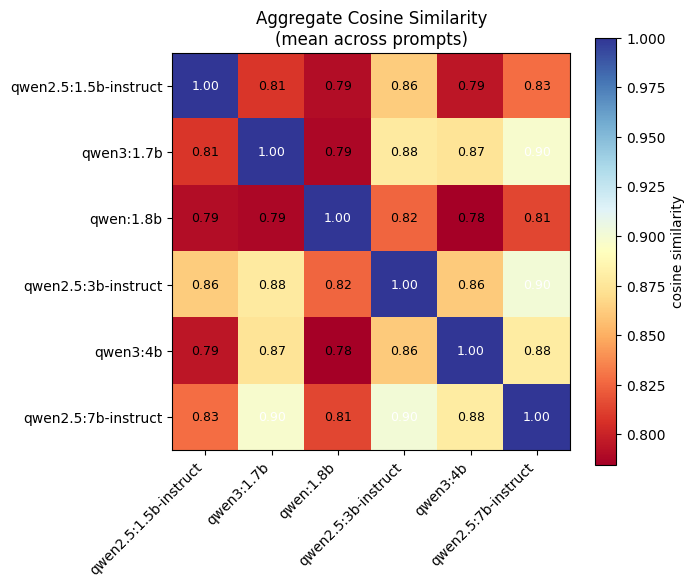

In [ ]:

# ── FR-10: Aggregate cosine heatmap ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(max(4, M + 1), max(3, M)))
_vmin = float(np.nanmin(agg_cosine))
_vmax = float(np.nanmax(agg_cosine))
im = ax.imshow(agg_cosine, vmin=_vmin, vmax=_vmax, cmap="RdYlBu")
ax.set_xticks(range(M))
ax.set_xticklabels(generator_aliases, rotation=45, ha="right")
ax.set_yticks(range(M))
ax.set_yticklabels(generator_aliases)
ax.set_title("Aggregate Cosine Similarity\n(mean across prompts)")
plt.colorbar(im, ax=ax, label="cosine similarity")
for i in range(M):
    for j in range(M):
        if not np.isnan(agg_cosine[i, j]):
            ax.text(
                j, i,
                f"{agg_cosine[i, j]:.2f}",
                ha="center", va="center",
                fontsize=9,
                color="black",
            )
plt.tight_layout()
plt.show()


In [ ]:

def plot_cosine_heatmap_for_prompt(prompt_index: int) -> None:
    """
    Plot the cosine heatmap for a specific prompt by index.
    Args:
        prompt_index: The index of the prompt to plot (0-based position in sorted prompt_ids).
    Returns:
        None. Displays a heatmap of cosine similarities for the specified prompt, 
        with the prompt text preview in the title.
    """
    sorted_pids = sorted(ok_df["prompt_id"].unique())
    pid = sorted_pids[prompt_index]
    mat = per_prompt_cosine[pid]

    # Get a preview of the prompt text for the title (first 60 chars, single line)
    prompt_preview = prompts[pid][:60].replace("\n", " ")
    if len(prompts[pid]) > 60:
        prompt_preview += "…"

    _vmin = float(np.nanmin(mat))
    _vmax = float(np.nanmax(mat))

    fig, ax = plt.subplots(figsize=(max(4, M + 1), max(3, M)))
    im = ax.imshow(mat, vmin=_vmin, vmax=_vmax, cmap="RdYlBu")
    ax.set_xticks(range(M))
    ax.set_xticklabels(generator_aliases, rotation=45, ha="right")
    ax.set_yticks(range(M))
    ax.set_yticklabels(generator_aliases)
    fig.suptitle(f"Cosine Similarity for prompt_{pid}", fontsize=11, y=1.0)
    ax.set_title(f'"{prompt_preview}"', fontsize=10, color="gray", style="italic", pad=4)
    plt.colorbar(im, ax=ax, label="cosine similarity")
    for i in range(M):
        for j in range(M):
            if not np.isnan(mat[i, j]):
                ax.text(
                    j, i,
                    f"{mat[i, j]:.2f}",
                    ha="center", va="center",
                    fontsize=9,
                    color="black",
                )
    plt.tight_layout()
    plt.show()
    plt.close(fig)


In [38]:
# ── Interactive dropdown ───────────────────────────────────────────────────────
sorted_pids = sorted(ok_df["prompt_id"].unique())
dropdown = widgets.Dropdown(
    options=[(f"prompt_{pid}", i) for i, pid in enumerate(sorted_pids)],
    description="Prompt:",
)
widgets.interact(plot_cosine_heatmap_for_prompt, prompt_index=dropdown)

interactive(children=(Dropdown(description='Prompt:', options=(('prompt_0', 0), ('prompt_1', 1), ('prompt_2', …

<function __main__.plot_cosine_heatmap_for_prompt(prompt_index: int) -> None>

### 4.4 Aggregate cosine heatmap between prompts (mean across models)

In [39]:
# ── Compute prompt × prompt cosine matrices per model, aggregate across models ─
prompt_ids    = sorted(ok_df["prompt_id"].unique())
N             = len(prompt_ids)
pid_to_idx    = {pid: idx for idx, pid in enumerate(prompt_ids)}
prompt_labels = [f"prompt_{pid}" for pid in prompt_ids]

per_model_prompt_cosine: dict[str, np.ndarray] = {}

for alias in generator_aliases:
    sub   = ok_df[ok_df["model_alias"] == alias].set_index("prompt_id")
    mat   = np.full((N, N), np.nan)
    for i, pi in enumerate(prompt_ids):
        for j, pj in enumerate(prompt_ids):
            if pi in sub.index and pj in sub.index:
                mat[i, j] = cosine_sim(
                    sub.loc[pi, "embedding"], sub.loc[pj, "embedding"]
                )
    per_model_prompt_cosine[alias] = mat

# Aggregate: mean across models (ignoring NaN)
agg_prompt_cosine = np.nanmean(np.stack(list(per_model_prompt_cosine.values())), axis=0)
print("\nAggregate cosine matrix (prompt × prompt, mean across models):")
print(pd.DataFrame(agg_prompt_cosine, index=prompt_labels, columns=prompt_labels).round(4))


Aggregate cosine matrix (prompt × prompt, mean across models):
          prompt_0  prompt_1  prompt_2  prompt_3  prompt_4  prompt_5  \
prompt_0    1.0000    0.8363    0.7902    0.8039    0.8065    0.6899   
prompt_1    0.8363    1.0000    0.8282    0.8470    0.8783    0.6796   
prompt_2    0.7902    0.8282    1.0000    0.8121    0.8642    0.6804   
prompt_3    0.8039    0.8470    0.8121    1.0000    0.8704    0.6619   
prompt_4    0.8065    0.8783    0.8642    0.8704    1.0000    0.6732   
prompt_5    0.6899    0.6796    0.6804    0.6619    0.6732    1.0000   
prompt_6    0.7982    0.8798    0.8403    0.8953    0.8995    0.6800   
prompt_7    0.7411    0.7780    0.7312    0.7570    0.7417    0.7616   

          prompt_6  prompt_7  
prompt_0    0.7982    0.7411  
prompt_1    0.8798    0.7780  
prompt_2    0.8403    0.7312  
prompt_3    0.8953    0.7570  
prompt_4    0.8995    0.7417  
prompt_5    0.6800    0.7616  
prompt_6    1.0000    0.7661  
prompt_7    0.7661    1.0000  


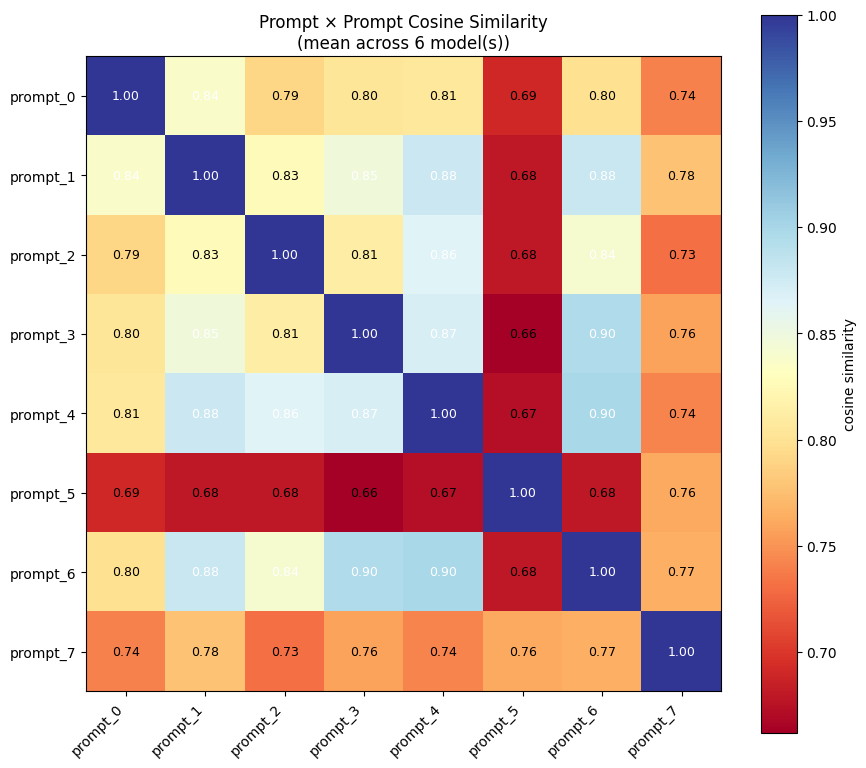

In [ ]:

# ── Prompt × prompt cosine heatmap (mean across models) ───────────────────────
fig, ax = plt.subplots(figsize=(max(4, N + 1), max(3, N)))
_vmin = float(np.nanmin(agg_prompt_cosine))
_vmax = float(np.nanmax(agg_prompt_cosine))
im = ax.imshow(agg_prompt_cosine, vmin=_vmin, vmax=_vmax, cmap="RdYlBu")
ax.set_xticks(range(N))
ax.set_xticklabels(prompt_labels, rotation=45, ha="right")
ax.set_yticks(range(N))
ax.set_yticklabels(prompt_labels)
ax.set_title(f"Prompt × Prompt Cosine Similarity\n(mean across {len(generator_aliases)} model(s))")
plt.colorbar(im, ax=ax, label="cosine similarity")
for i in range(N):
    for j in range(N):
        if not np.isnan(agg_prompt_cosine[i, j]):
            ax.text(
                j, i,
                f"{agg_prompt_cosine[i, j]:.2f}",
                ha="center", va="center",
                fontsize=9,
                color="black",
            )
plt.tight_layout()
plt.show()


In [ ]:

# Prompt × prompt cosine heatmaps per model (interactive dropdown) ─────────────────
def plot_prompt_cosine_heatmap_for_model(model_alias: str) -> None:
    """Plot the prompt × prompt cosine heatmap for a specific model alias.
    Args:
        model_alias: The model alias to plot (must be one of the generator aliases).
    Returns:
        None. Displays a heatmap of cosine similarities for the specified model.
    """
    mat = per_model_prompt_cosine[model_alias]
    _vmin = float(np.nanmin(mat))
    _vmax = float(np.nanmax(mat))
    fig, ax = plt.subplots(figsize=(max(4, N + 1), max(3, N)))
    im = ax.imshow(mat, vmin=_vmin, vmax=_vmax, cmap="RdYlBu")
    ax.set_xticks(range(N))
    ax.set_xticklabels(prompt_labels, rotation=45, ha="right")
    ax.set_yticks(range(N))
    ax.set_yticklabels(prompt_labels)
    ax.set_title(f"Prompt × Prompt Cosine Similarity for {model_alias}")
    plt.colorbar(im, ax=ax, label="cosine similarity")
    for i in range(N):
        for j in range(N):
            if not np.isnan(mat[i, j]):
                ax.text(
                    j, i,
                    f"{mat[i, j]:.2f}",
                    ha="center", va="center",
                    fontsize=9,
                    color="black",
                )
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # prevent duplicate renders in VS Code


In [42]:
# ── Interactive dropdown ───────────────────────────────────────────────────────
dropdown = widgets.Dropdown(
    options=generator_aliases,
    description="Model:",
)
widgets.interact(plot_prompt_cosine_heatmap_for_model, model_alias=dropdown)

interactive(children=(Dropdown(description='Model:', options=('qwen2.5:1.5b-instruct', 'qwen3:1.7b', 'qwen:1.8…

<function __main__.plot_prompt_cosine_heatmap_for_model(model_alias: str) -> None>

## 5. Next Steps

- Use better semantic similarity metrics.
- Have another LLM be the semantic similarity judge.
- Use a frontier reasoning model to act as a 'base truth'/benchmark against the smaller models.
- Control for prompt length (limit to 100 words, 200, 500, etc.)
- Control for prompt response lengeth (300 words, 500 words, et.)